## **Introduction to Image Processing**

## Interpolation and Blending

 Importing necessary libraries/modules and functions

In [1]:
% matplotlib inline
% pprint off


# Import the library as show images, plot, etc.
import matplotlib.pyplot as plt
# Import functionality for the color map
import matplotlib.cm as cm

# Import system specific parameters and function
import sys 

## Other plotting libraries
# import seaborn as sns

# Import the library to mange the matrix and array 
import numpy as np

# Importing image processing toolbox 
## Module to read, write,... 
from skimage import io
## Module to convert the image on 8 bits
from skimage import img_as_ubyte
## Module to convert the image to float
from skimage import img_as_float
## Module for color conversion 
from skimage import color
## Module image transform from skimage for resize 
from skimage import transform
## Module misc from scipy for resize 
from scipy import misc
## Module util from skimage 
from PIL import Image


Pretty printing has been turned OFF


### ** Resizing an image size using different interpolation functions**

**1. ** Resize the lena or vibot image using nearest, bilinear and bicubic function.

You can define your function which accept the model and resize size from the user or just run a script.

The resize method is nearest


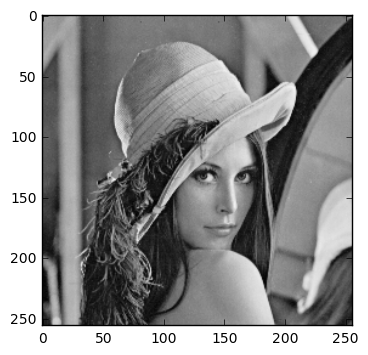

The resize method is bilinear


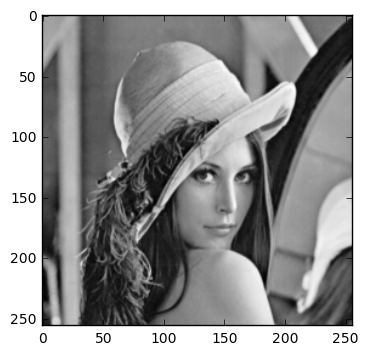

The resize method is bicubic


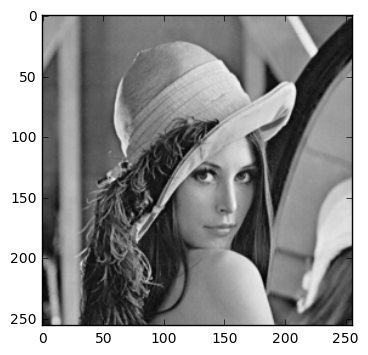

In [2]:
def ImResize (im, method='nearest', size= 0.5):
    print 'The resize method is {}'.format(method)
    im_resize = misc.imresize(im, size, interp = method)
    return im_resize



Path = './images/'
image_name = 'lena-grey.bmp'
lena_im = io.imread(Path.__add__(image_name))
lena_im = img_as_float(lena_im)
methods = ['nearest', 'bilinear', 'bicubic']
for m in methods:
    im_resize = ImResize(lena_im,m, 0.5)
    plt.figure
    plt.imshow(im_resize, cmap=plt.cm.gray)
    plt.show()  
    
    


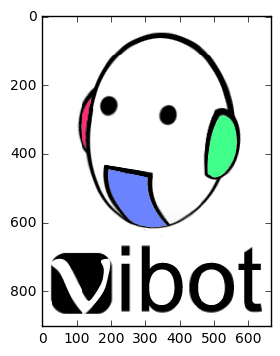

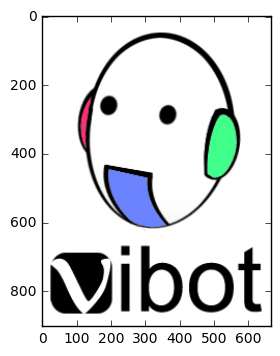

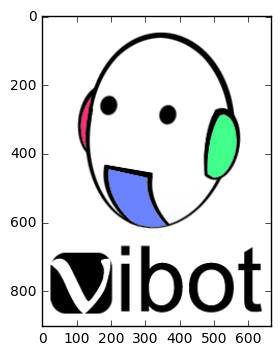

In [3]:
#plt.figure
#plt.imshow(im_resize, cmap=plt.cm.gray)
#plt.show()  
vibot = io.imread("./images/vibot-color.jpg")
plt.figure()
plt.imshow(misc.imresize(vibot, 3.0, "nearest"), cmap=plt.cm.gray)

plt.figure()
plt.imshow(misc.imresize(vibot, 3.0, "bilinear"), cmap=plt.cm.gray)
#io.imsave

plt.figure()
plt.imshow(misc.imresize(vibot, 3.0, "bicubic"), cmap=plt.cm.gray)



**2. ** Similar to the function of `my_blending.m` that you saw before define your function of blending.

Blend the lena image and vibot image using simple, alpha and pyramid method.   

Pyramid blending method: 
1. Create a mask the same size as your input images 
2. Create Laplacian pyramid of the input images 
    2.1. Create Gaussian pyramids of the input images
    2.2. Create Laplacian pyramids using the Gaussian pyramids
3. Create Gaussian pyramid for the region mask
4. Blend the two laplacian pyramids using the pyramid of the mask as weigh 
    $$ BL = L_1 * (GM) + L_2 *(1 - GM)$$
5. Colapse the pyramid to get the final image 
    $$rescale(rescale(rescale(BL_3)+BL_2)+BL_1)+BL_0$$

Note : For pyramid blending approach, you can use:
    * transform.rescale for upscaling your images
    * transform.pyramid_gaussian for building your pyramids
    * The output of transform.pyramid_gaussian is a type generator and you need to convert it to a list :
    
        b = [a for a in Gaussian_pyramid]


In [10]:
def blendit(im1, im2, method="simple", mask=None):
    if(im1.shape != im2.shape):
        raise ValueError('Images must be same size')
        return
    
   
    
    if(method is "simple"):
        print("Method is simple")
        im_out = np.zeros(im1.shape)
        im_out[:, 0: int(im_out.shape[1]/2)] =  im1[:, 0:int(im1.shape[1]/2)]
        im_out[:, int(im_out.shape[1]/2):] =  im2[:, int(im1.shape[1]/2):]
        return im_out
        
    if(method is "alpha"):
        print("Method is alpha")
        alpha_window = 11
        alpha_image = np.zeros((im1.shape[0],alpha_window*2,3))
        alpha_image[:,:,0] = alpha_image[:,:,1] = alpha_image[:,:,2] = \
            np.tile(np.linspace(0, 1, alpha_window*2, endpoint=True), (im1.shape[0],1))
        
        #Initialize image with simple blending
        im_out = np.zeros(im1.shape)
        im_out[:, 0: int(im_out.shape[1]/2)] =  im1[:, 0:int(im1.shape[1]/2)]
        im_out[:, int(im_out.shape[1]/2):] =  im2[:, int(im2.shape[1]/2):]
        
        #Fill masked region 
        im_out[:, int(im_out.shape[1]/2)-alpha_window:int(im_out.shape[1]/2)+alpha_window] = \
        im1[:, int(im_out.shape[1]/2)-alpha_window:int(im_out.shape[1]/2)+alpha_window]*(1-alpha_image) + \
        im2[:, int(im_out.shape[1]/2)-alpha_window:int(im_out.shape[1]/2)+alpha_window]*alpha_image 
        
        return im_out
    
    if(method is "pyramid"):
        print("Method is pyramid")
        if(mask == None):
            mask_mono = np.ones((im1.shape[0], im2.shape[1]))
            mask_mono[:, int(im1.shape[1]/2):] = mask_mono[:, int(im1.shape[1]/2):] - 1.0
            
            mask = np.zeros((mask_mono.shape[0], mask_mono.shape[1], 3))
            mask[:,:,0] = mask[:,:,1] = mask[:,:,2] = mask_mono
        
        #Create Gaussian pyramid by rescaling of mask, image1, image2
        num_layers = 5
        pyr_gauss_mask = [a for a in transform.pyramid_gaussian(mask, max_layer=num_layers)]
        pyr_gauss_im1 = [b for b in transform.pyramid_gaussian(im1, max_layer=num_layers)]
        pyr_gauss_im2 = [c for c in transform.pyramid_gaussian(im2, max_layer=num_layers)]
        
        #Create laplacian pyramid by substracting rescaled version of image 1, image 2
        pyr_lap_im1 = list(pyr_gauss_im1)
        pyr_lap_im2 = list(pyr_gauss_im2)
        
        for i in range(num_layers-1):
            pyr_lap_im1[i] -= transform.resize(transform.rescale(pyr_lap_im1[i+1], 2), pyr_lap_im1[i].shape)
            pyr_lap_im2[i] -= transform.resize(transform.rescale(pyr_lap_im2[i+1], 2), pyr_lap_im2[i].shape)
        
        #Create laplacian pyramid of result by using mask multpilication pyramid with both images laplacian pyramids
        pyr_lap_output = list(pyr_lap_im1)
        for i in range(num_layers):
            pyr_lap_output[i] =  pyr_lap_im1[i] * pyr_gauss_mask[i] + pyr_lap_im2[i] * (1 - pyr_gauss_mask[i])
        
        #Recompose final image using laplacian pyramid levels
        im_out = pyr_lap_output[num_layers-1]
        for i in range(num_layers-2,-1,-1):    
            im_out = transform.resize(transform.rescale(im_out, 2),pyr_lap_output[i].shape) + pyr_lap_output[i]
        
        return im_out

Use the `orange.jpeg` and `apple.jpeg` imgages and blend them using simple, alpha and pyramid approach.

In [11]:
#simple
img_orange = io.imread("./images/orange.jpeg")
img_apple =  io.imread("./images/apple.jpeg")

im_blended_simple = blendit(img_orange, img_apple, "simple")
im_blended_alpha = blendit(img_orange, img_apple, "alpha")
im_blended_pyramid = blendit(img_orange, img_apple, "pyramid")

Method is simple
Method is alpha
Method is pyramid


Show the your answers.

C:\Users\Elitebook\Anaconda2\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


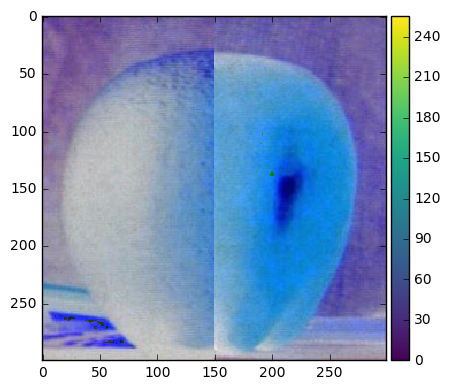

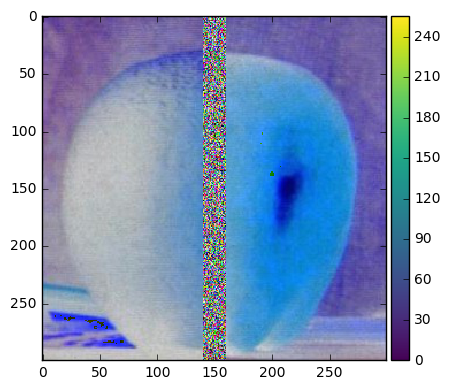

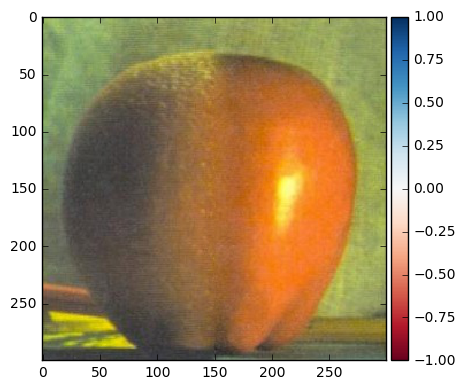

In [6]:
io.imshow(im_blended_simple)

io.show()

io.imshow(im_blended_alpha)

io.show()

io.imshow(im_blended_pyramid)

In [7]:
def blend(im1,im2):
    im_out = np.zeros(im1.shape)
    im_out[:, 0: int(im_out.shape[1]/2)] =im1[:, 0:int(im1.shape[1]/2)]
    im_out[:, int(im_out.shape[1]/2):] =  im2[:, int(im1.shape[1]/2):]
    return im_out



In [8]:
img_orange = io.imread("./images/orange.jpeg")
img_apple =  io.imread("./images/apple.jpeg")




im_blended_simple = blend(img_orange, img_apple)

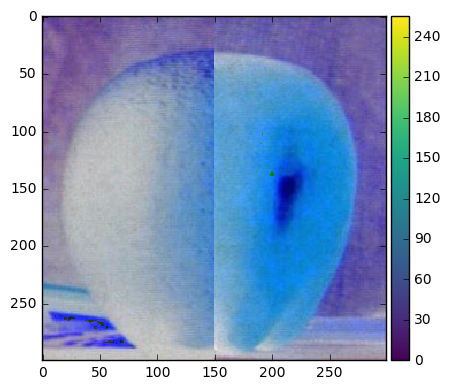

In [9]:
io.imshow(im_blended_simple)

io.show()